#BERT4REC_Steam_Datasets

Epoch 1: 100%|██████████| 443/443 [00:12<00:00, 36.20it/s]


Epoch 1 - Loss: 2979.71, Recall@10: 0.3070, MRR@10: 0.1504, NDCG@10: 0.1870


Epoch 2: 100%|██████████| 443/443 [00:12<00:00, 36.07it/s]


Epoch 2 - Loss: 2403.66, Recall@10: 0.3305, MRR@10: 0.1606, NDCG@10: 0.2002


Epoch 3: 100%|██████████| 443/443 [00:12<00:00, 36.30it/s]


Epoch 3 - Loss: 2072.42, Recall@10: 0.3349, MRR@10: 0.1585, NDCG@10: 0.1999


Epoch 4: 100%|██████████| 443/443 [00:12<00:00, 36.39it/s]


Epoch 4 - Loss: 1856.47, Recall@10: 0.3190, MRR@10: 0.1521, NDCG@10: 0.1914


Epoch 5: 100%|██████████| 443/443 [00:12<00:00, 36.17it/s]


Epoch 5 - Loss: 1727.62, Recall@10: 0.3408, MRR@10: 0.1659, NDCG@10: 0.2070


Epoch 6: 100%|██████████| 443/443 [00:12<00:00, 36.26it/s]


Epoch 6 - Loss: 1639.84, Recall@10: 0.3691, MRR@10: 0.1812, NDCG@10: 0.2252


Epoch 7: 100%|██████████| 443/443 [00:12<00:00, 35.97it/s]


Epoch 7 - Loss: 1584.09, Recall@10: 0.3608, MRR@10: 0.1775, NDCG@10: 0.2204


Epoch 8: 100%|██████████| 443/443 [00:12<00:00, 36.25it/s]


Epoch 8 - Loss: 1540.17, Recall@10: 0.3729, MRR@10: 0.1899, NDCG@10: 0.2330


Epoch 9: 100%|██████████| 443/443 [00:12<00:00, 36.24it/s]


Epoch 9 - Loss: 1503.39, Recall@10: 0.3847, MRR@10: 0.1968, NDCG@10: 0.2410


Epoch 10: 100%|██████████| 443/443 [00:12<00:00, 36.37it/s]


Epoch 10 - Loss: 1475.35, Recall@10: 0.3905, MRR@10: 0.1978, NDCG@10: 0.2430


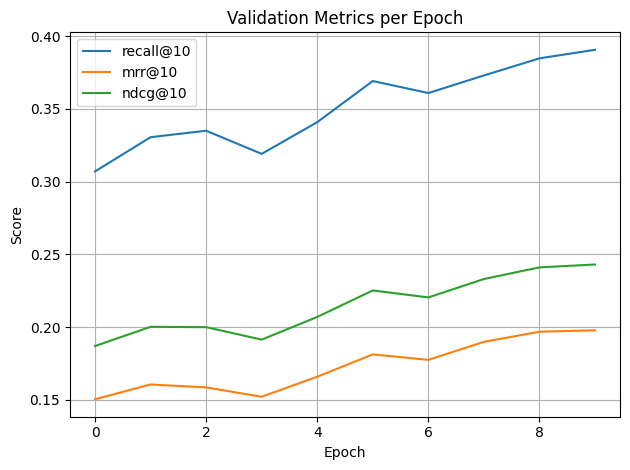

Sample Predictions:
User 1 ground truth: 256, Top-10 prediction: [244, 764, 662, 1899, 752, 187, 198, 1339, 254, 262]
User 2 ground truth: 179, Top-10 prediction: [179, 158, 815, 396, 180, 1247, 281, 163, 141, 407]
User 3 ground truth: 193, Top-10 prediction: [1038, 1303, 1361, 257, 192, 1479, 1484, 1896, 1370, 1493]
User 4 ground truth: 1904, Top-10 prediction: [277, 1904, 409, 2532, 2612, 1551, 260, 1004, 2224, 2086]
User 5 ground truth: 1773, Top-10 prediction: [277, 276, 2532, 409, 1072, 1552, 1668, 2612, 260, 1522]


In [5]:
import json, gzip, ast, random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import BertConfig, BertModel
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import defaultdict

MAX_SEQ_LEN = 50
MASK_PROB = 0.2
BATCH_SIZE = 128
EPOCHS = 10
PATIENCE = 3
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
INPUT_JSON = 'users_items.json'
MODEL_SAVE_PATH = "bert4rec_steam.pt"

def load_and_preprocess(json_file):
    with open(json_file, 'rb') as f:
        is_gzip = f.read(2) == b'\x1f\x8b'
    open_fn = gzip.open if is_gzip else open

    raw_data = []
    with open_fn(json_file, 'rt', encoding='utf-8', errors='ignore') as f:
        for line in f:
            try:
                obj = json.loads(line)
            except:
                try:
                    obj = ast.literal_eval(line)
                except:
                    continue
            raw_data.append(obj)

    user2seq, item2id, id_counter = {}, {}, 1
    for user in raw_data:
        uid = user.get("user_id")
        items = user.get("items", [])
        seq = []
        for item in items:
            iid = item.get("item_id")
            if iid not in item2id:
                item2id[iid] = id_counter
                id_counter += 1
            seq.append(item2id[iid])
        if len(seq) >= 5:
            user2seq[uid] = seq

    return list(user2seq.values()), item2id, len(item2id) + 1

class BERT4RecDataset(Dataset):
    def __init__(self, sequences, vocab_size, max_len=MAX_SEQ_LEN, mask_prob=MASK_PROB, eval_mode=False):
        self.eval_mode = eval_mode
        self.sequences = sequences
        self.vocab_size = vocab_size
        self.max_len = max_len
        self.mask_prob = mask_prob

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        seq = self.sequences[idx][-self.max_len:]
        if self.eval_mode:
            input_seq = seq[:-1][-self.max_len:]
            target = seq[-1]
            input_seq = [0] * (self.max_len - len(input_seq)) + input_seq
            return torch.tensor(input_seq), torch.tensor(target)
        else:
            input_seq, labels = seq.copy(), [-100] * len(seq)
            for i in range(len(seq)):
                if random.random() < self.mask_prob:
                    labels[i], input_seq[i] = seq[i], 0
            input_seq = [0] * (self.max_len - len(seq)) + input_seq
            labels = [-100] * (self.max_len - len(seq)) + labels
            return torch.tensor(input_seq), torch.tensor(labels)

class BERT4RecModel(nn.Module):
    def __init__(self, vocab_size, hidden_size=256, num_layers=2, num_heads=4):
        super().__init__()
        config = BertConfig(
            vocab_size=vocab_size, hidden_size=hidden_size,
            num_attention_heads=num_heads, num_hidden_layers=num_layers,
            max_position_embeddings=MAX_SEQ_LEN + 1, type_vocab_size=1
        )
        self.bert = BertModel(config)
        self.out = nn.Linear(hidden_size, vocab_size)

    def forward(self, input_ids):
        mask = (input_ids != 0).long()
        x = self.bert(input_ids=input_ids, attention_mask=mask)
        return self.out(x.last_hidden_state)

def recall_at_k(pred, true, k): return 1.0 if true in pred[:k] else 0.0
def mrr_at_k(pred, true, k): return 1.0 / (pred.index(true) + 1) if true in pred[:k] else 0.0
def ndcg_at_k(pred, true, k): return 1.0 / np.log2(pred.index(true) + 2) if true in pred[:k] else 0.0

def evaluate_metrics(model, dataset, vocab_size, k=10):
    model.eval()
    recalls, mrrs, ndcgs = [], [], []
    loader = DataLoader(dataset, batch_size=64)
    with torch.no_grad():
        for x, y in loader:
            x = x.to(DEVICE)
            logits = model(x)[:, -1, :]
            topk = torch.topk(logits, k=k, dim=-1).indices.cpu().numpy()
            y = y.numpy()
            for pred, true in zip(topk, y):
                pred = list(pred)
                recalls.append(recall_at_k(pred, true, k))
                mrrs.append(mrr_at_k(pred, true, k))
                ndcgs.append(ndcg_at_k(pred, true, k))
    return {'recall@10': np.mean(recalls), 'mrr@10': np.mean(mrrs), 'ndcg@10': np.mean(ndcgs)}

def train_model(model, train_loader, val_dataset, vocab_size):
    optimizer = optim.AdamW(model.parameters(), lr=3e-4)
    criterion = nn.CrossEntropyLoss(ignore_index=-100)
    best_loss = float('inf')
    patience = 0
    metrics = defaultdict(list)

    for epoch in range(EPOCHS):
        model.train()
        total_loss = 0
        for x, y in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            x, y = x.to(DEVICE), y.to(DEVICE)
            logits = model(x)
            loss = criterion(logits.view(-1, vocab_size), y.view(-1))
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            total_loss += loss.item()

        val = evaluate_metrics(model, val_dataset, vocab_size)
        print(f"Epoch {epoch+1} - Loss: {total_loss:.2f}, Recall@10: {val['recall@10']:.4f}, MRR@10: {val['mrr@10']:.4f}, NDCG@10: {val['ndcg@10']:.4f}")
        for k, v in val.items(): metrics[k].append(v)

        if total_loss < best_loss:
            best_loss = total_loss
            patience = 0
            torch.save(model.state_dict(), MODEL_SAVE_PATH)
        else:
            patience += 1
            if patience >= PATIENCE: break
    return metrics

def plot_metrics(metrics):
    for metric in metrics:
        plt.plot(metrics[metric], label=metric)
    plt.title("Validation Metrics per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.savefig("metrics_plot.png")
    plt.show()

if __name__ == "__main__":
    sequences, item2id, vocab_size = load_and_preprocess(INPUT_JSON)
    random.shuffle(sequences)
    split = int(0.9 * len(sequences))
    train_seq, val_seq = sequences[:split], sequences[split:]

    train_loader = DataLoader(BERT4RecDataset(train_seq, vocab_size), batch_size=BATCH_SIZE, shuffle=True)
    val_dataset = BERT4RecDataset(val_seq, vocab_size, eval_mode=True)

    model = BERT4RecModel(vocab_size).to(DEVICE)
    metrics = train_model(model, train_loader, val_dataset, vocab_size)
    plot_metrics(metrics)

    print("Sample Predictions:")
    model.eval()
    with torch.no_grad():
        for i, seq in enumerate(val_seq[:5]):
            prefix = seq[:-1][-MAX_SEQ_LEN:]
            input_seq = [0] * (MAX_SEQ_LEN - len(prefix)) + prefix
            input_tensor = torch.tensor(input_seq).unsqueeze(0).to(DEVICE)
            logits = model(input_tensor)[:, -1, :]
            top_items = torch.topk(logits, k=10, dim=-1).indices[0].cpu().tolist()
            print(f"User {i+1} ground truth: {seq[-1]}, Top-10 prediction: {top_items}")

In [2]:
pip install transformers datasets torch tqdm scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 51.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 44.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 35.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 879.3 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 72.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
#xLSTM

In [27]:
import os
import zipfile
import requests
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import sys
from torch.cuda.amp import autocast, GradScaler

# Optional: For debugging CUDA errors, uncomment the following line before running script:
# os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

# Install required packages:
# pip install mlstm_kernels
# pip install xlstm

sys.path.append("../..")
from xlstm.xlstm_large.model import xLSTMLargeConfig, xLSTMLarge

# -----------------------------
# 1. Download and extract MovieLens 1M dataset
# -----------------------------

DATA_URL = "https://files.grouplens.org/datasets/movielens/ml-1m.zip"
DATA_DIR = "ml-1m"

if not os.path.exists(DATA_DIR):
    print("Downloading MovieLens 1M dataset...")
    r = requests.get(DATA_URL)
    with open("ml-1m.zip", "wb") as f:
        f.write(r.content)
    with zipfile.ZipFile("ml-1m.zip", 'r') as zip_ref:
        zip_ref.extractall(".")
    print("Extraction complete.")

# -----------------------------
# 2. Load and process data
# -----------------------------

print("Loading data...")
rating_df = pd.read_csv(os.path.join(DATA_DIR, "ratings.dat"), sep="::", engine='python',
                        names=['user_id', 'movie_id', 'rating', 'timestamp'])
print("Sample ratings:")
print(rating_df.head())

rating_df.sort_values(by=['user_id', 'timestamp'], inplace=True)

user2id = {uid: i for i, uid in enumerate(rating_df['user_id'].unique())}
item2id = {iid: i for i, iid in enumerate(rating_df['movie_id'].unique())}
rating_df['user_id'] = rating_df['user_id'].map(user2id)
rating_df['movie_id'] = rating_df['movie_id'].map(item2id)

num_users = len(user2id)
num_items = len(item2id)
print(f"Number of users: {num_users}, Number of items: {num_items}")

user_seqs = rating_df.groupby('user_id')['movie_id'].apply(list).to_dict()

# -----------------------------
# 3. Dataset and DataLoader
# -----------------------------

class MovieLensDataset(Dataset):
    def __init__(self, user_sequences, max_len=50):
        self.samples = []
        self.max_len = max_len
        for user, items in user_sequences.items():
            for i in range(1, len(items)):
                seq = items[max(0, i - max_len):i]
                target = items[i]
                self.samples.append((seq, target))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        seq, target = self.samples[idx]
        # Pad sequences with 0 (assumed padding index)
        seq = [0] * (self.max_len - len(seq)) + seq
        return torch.tensor(seq, dtype=torch.long), torch.tensor(target, dtype=torch.long)

train_dataset = MovieLensDataset(user_seqs, max_len=50)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2, pin_memory=True)

# -----------------------------
# 4. True xLSTM Large Model
# -----------------------------

xlstm_config = xLSTMLargeConfig(
    embedding_dim=256,
    num_heads=4,
    num_blocks=3,
    vocab_size=num_items + 1,  # +1 for padding index 0
    return_last_states=True,
    mode="inference",
    chunkwise_kernel="chunkwise--triton_xl_chunk",
    sequence_kernel="native_sequence__triton",
    step_kernel="triton",
)

model = xLSTMLarge(xlstm_config)
print("xLSTM Model Architecture:")
print(model)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
try:
    print(f"Attempting to move model to device: {device}")
    print(f"Embedding layer shape: {model.embedding.weight.shape if hasattr(model.embedding, 'weight') else 'N/A'}")
    print(f"LM head out_features: {model.lm_head.out_features if hasattr(model.lm_head, 'out_features') else 'N/A'}")
    model.to(device)
except RuntimeError as e:
    print("[ERROR] Failed to move model to device:")
    print(e)
    print("Suggestion: Set chunkwise_kernel, sequence_kernel, and step_kernel to 'native_autograd' for compatibility.")
    print("Model config summary:")
    print(f" - Embedding shape: {model.embedding.weight.shape if hasattr(model.embedding, 'weight') else 'N/A'}")
    print(f" - lm_head out_features: {model.lm_head.out_features if hasattr(model.lm_head, 'out_features') else 'N/A'}")
    print(f" - Vocab size: {xlstm_config.vocab_size}")
    raise

# -----------------------------
# 5. Evaluation Metrics
# -----------------------------

def recall_mrr_ndcg_k(preds, targets, k=10):
    recall, mrr, ndcg = 0.0, 0.0, 0.0
    for pred, target in zip(preds, targets):
        if target in pred[:k]:
            recall += 1
            rank = pred[:k].index(target)
            mrr += 1.0 / (rank + 1)
            ndcg += 1.0 / np.log2(rank + 2)
    n = len(preds)
    return recall / n, mrr / n, ndcg / n

# -----------------------------
# 6. Training Loop (with AMP)
# -----------------------------

# Use ignore_index=0 to ignore padding tokens in loss calculation
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(model.parameters(), lr=0.001)
scaler = GradScaler()
recall_list, mrr_list, ndcg_list = [], [], []

print(f"Training using device: {device}")
print(f"Model is currently on: {next(model.parameters()).device}")

for epoch in range(10):
    model.train()
    total_loss = 0
    for seqs, targets in tqdm(train_loader):
        seqs, targets = seqs.to(device), targets.to(device)

        # Check targets are within valid range before loss computation
        if targets.min() < 0 or targets.max() >= xlstm_config.vocab_size:
            print(f"[ERROR] Target out of bounds: min={targets.min()}, max={targets.max()}")
            raise ValueError("Targets out of bounds for CrossEntropyLoss")

        optimizer.zero_grad()
        with autocast():
            outputs = model(seqs)
            logits = outputs[0] if isinstance(outputs, tuple) else outputs
            if logits.dim() == 3:
                logits = logits[:, -1, :]
            loss = criterion(logits, targets)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_loss += loss.item()

    model.eval()
    all_preds, all_targets = [], []
    with torch.no_grad():
        for seqs, targets in train_loader:
            seqs = seqs.to(device)
            outputs = model(seqs)
            logits = outputs[0] if isinstance(outputs, tuple) else outputs
            if logits.dim() == 3:
                logits = logits[:, -1, :]
            topk = torch.topk(logits, k=10, dim=-1).indices.cpu().tolist()
            all_preds.extend(topk)
            all_targets.extend(targets.tolist())

    recall, mrr, ndcg = recall_mrr_ndcg_k(all_preds, all_targets)
    recall_list.append(recall)
    mrr_list.append(mrr)
    ndcg_list.append(ndcg)
    print(f"Epoch {epoch+1} | Loss: {total_loss:.4f} | Recall@10: {recall:.4f} | MRR@10: {mrr:.4f} | NDCG@10: {ndcg:.4f}")

# -----------------------------
# 7. Plotting results
# -----------------------------

plt.figure()
plt.plot(recall_list, label='Recall@10')
plt.plot(mrr_list, label='MRR@10')
plt.plot(ndcg_list, label='NDCG@10')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.title('Evaluation Metrics')
plt.legend()
plt.grid(True)
plt.show()

# -----------------------------
# 8. Sample Predictions
# -----------------------------

print("\nSample predictions:")
model.eval()
sample_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
with torch.no_grad():
    for i, (seq, target) in enumerate(sample_loader):
        seq = seq.to(device)
        outputs = model(seq)
        logits = outputs[0] if isinstance(outputs, tuple) else outputs
        if logits.dim() == 3:
            logits = logits[:, -1, :]
        top10 = torch.topk(logits, k=10, dim=-1).indices.cpu().squeeze().tolist()
        print(f"Input sequence: {seq.cpu().squeeze().tolist()}")
        print(f"True next item: {target.item()}")
        print(f"Top-10 Predictions: {top10}\n")
        if i == 4:
            break

# -----------------------------
# Important:
# If you encounter the CUDA device-side assert error again,
# please restart your runtime/kernel before rerunning the script.
# -----------------------------


Loading data...
Sample ratings:
   user_id  movie_id  rating  timestamp
0        1      1193       5  978300760
1        1       661       3  978302109
2        1       914       3  978301968
3        1      3408       4  978300275
4        1      2355       5  978824291
Number of users: 6040, Number of items: 3706
xLSTM Model Architecture:
xLSTMLarge(
  (embedding): Embedding(3707, 256)
  (backbone): xLSTMLargeBlockStack(
    (blocks): ModuleList(
      (0-2): 3 x mLSTMBlock(
        (norm_mlstm): RMSNorm()
        (mlstm_layer): mLSTMLayer(
          (q): Linear(in_features=256, out_features=128, bias=False)
          (k): Linear(in_features=256, out_features=128, bias=False)
          (v): Linear(in_features=256, out_features=256, bias=False)
          (ogate_preact): Linear(in_features=256, out_features=256, bias=False)
          (igate_preact): Linear(in_features=256, out_features=4, bias=True)
          (fgate_preact): Linear(in_features=256, out_features=4, bias=True)
          

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
